`statsmodels` ARIMAX example. See: https://pyflux.readthedocs.io/en/latest/arimax.html



## Setting up our example

In [1]:
# set up Python
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
import plotnine
from plotnine import *
from nested_model_fns import plot_model_quality

# set plot size
plotnine.options.figure_size = (16, 8)

In [2]:
d_train = pd.read_csv("d_train.csv")
d_test = pd.read_csv("d_test.csv")

In [3]:
d_train

,time_tick,x_durable_0,x_transient_0,y,ext_regressors
0,0,0,0,219.0,regular point
1,1,0,0,221.0,regular point
2,2,0,0,230.0,regular point
3,3,0,0,214.0,regular point
4,4,0,0,208.0,regular point
...,...,...,...,...,...
975,975,0,1,9.0,transient impact
976,976,0,0,0.0,regular point
977,977,0,0,2.0,regular point
978,978,0,0,12.0,regular point


In [4]:
with open("generating_params.json", "r") as file:
    generating_params = json.load(file)


The generating and modeling lags specify translate into ARIMA terms as `p = 2, i = 0`. We take our own  advice from [A Time Series Apologia](https://github.com/WinVector/Examples/blob/main/TS/TS_example.md) and pick `q = p`. So in ARIMAX terms we try fitting a `pdq(2, 0, 2)` system.

In [5]:
model3 = sm.tsa.ARIMA(
    endog=d_train['y'],
    exog=d_train[['x_durable_0', 'x_transient_0']],
    order=[2, 0, 2],
)
fit3 = model3.fit()
print(fit3.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  980
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -3400.482
Date:                Sat, 01 Mar 2025   AIC                           6816.965
Time:                        07:15:12   BIC                           6856.065
Sample:                             0   HQIC                          6831.840
                                - 980                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            78.3796      2.908     26.956      0.000      72.681      84.078
x_durable_0      -0.4865      0.512     -0.950      0.342      -1.490       0.517
x_transient_0    17.0468      0.216     

In [6]:

generating_params

{'beta_auto_intercept': 2.1276366691753177,
 'effect_shift': -10.4,
 'beta_auto': [1.9727226068054446, -1],
 'beta_durable': [9.2],
 'beta_transient': [19.1],
 'generating_lags': [1, 2],
 'error_scale': 3.2,
 'n_step': 1000}

In [7]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.predict.html
d_test["statsmodels ARIMA (external regressors)"] = np.maximum(0, np.array(
    fit3.predict(
        start=d_train.shape[0],
        end=d_train.shape[0] + d_test.shape[0] - 1,
        exog=d_test[['x_durable_0', 'x_transient_0']],
        )
))

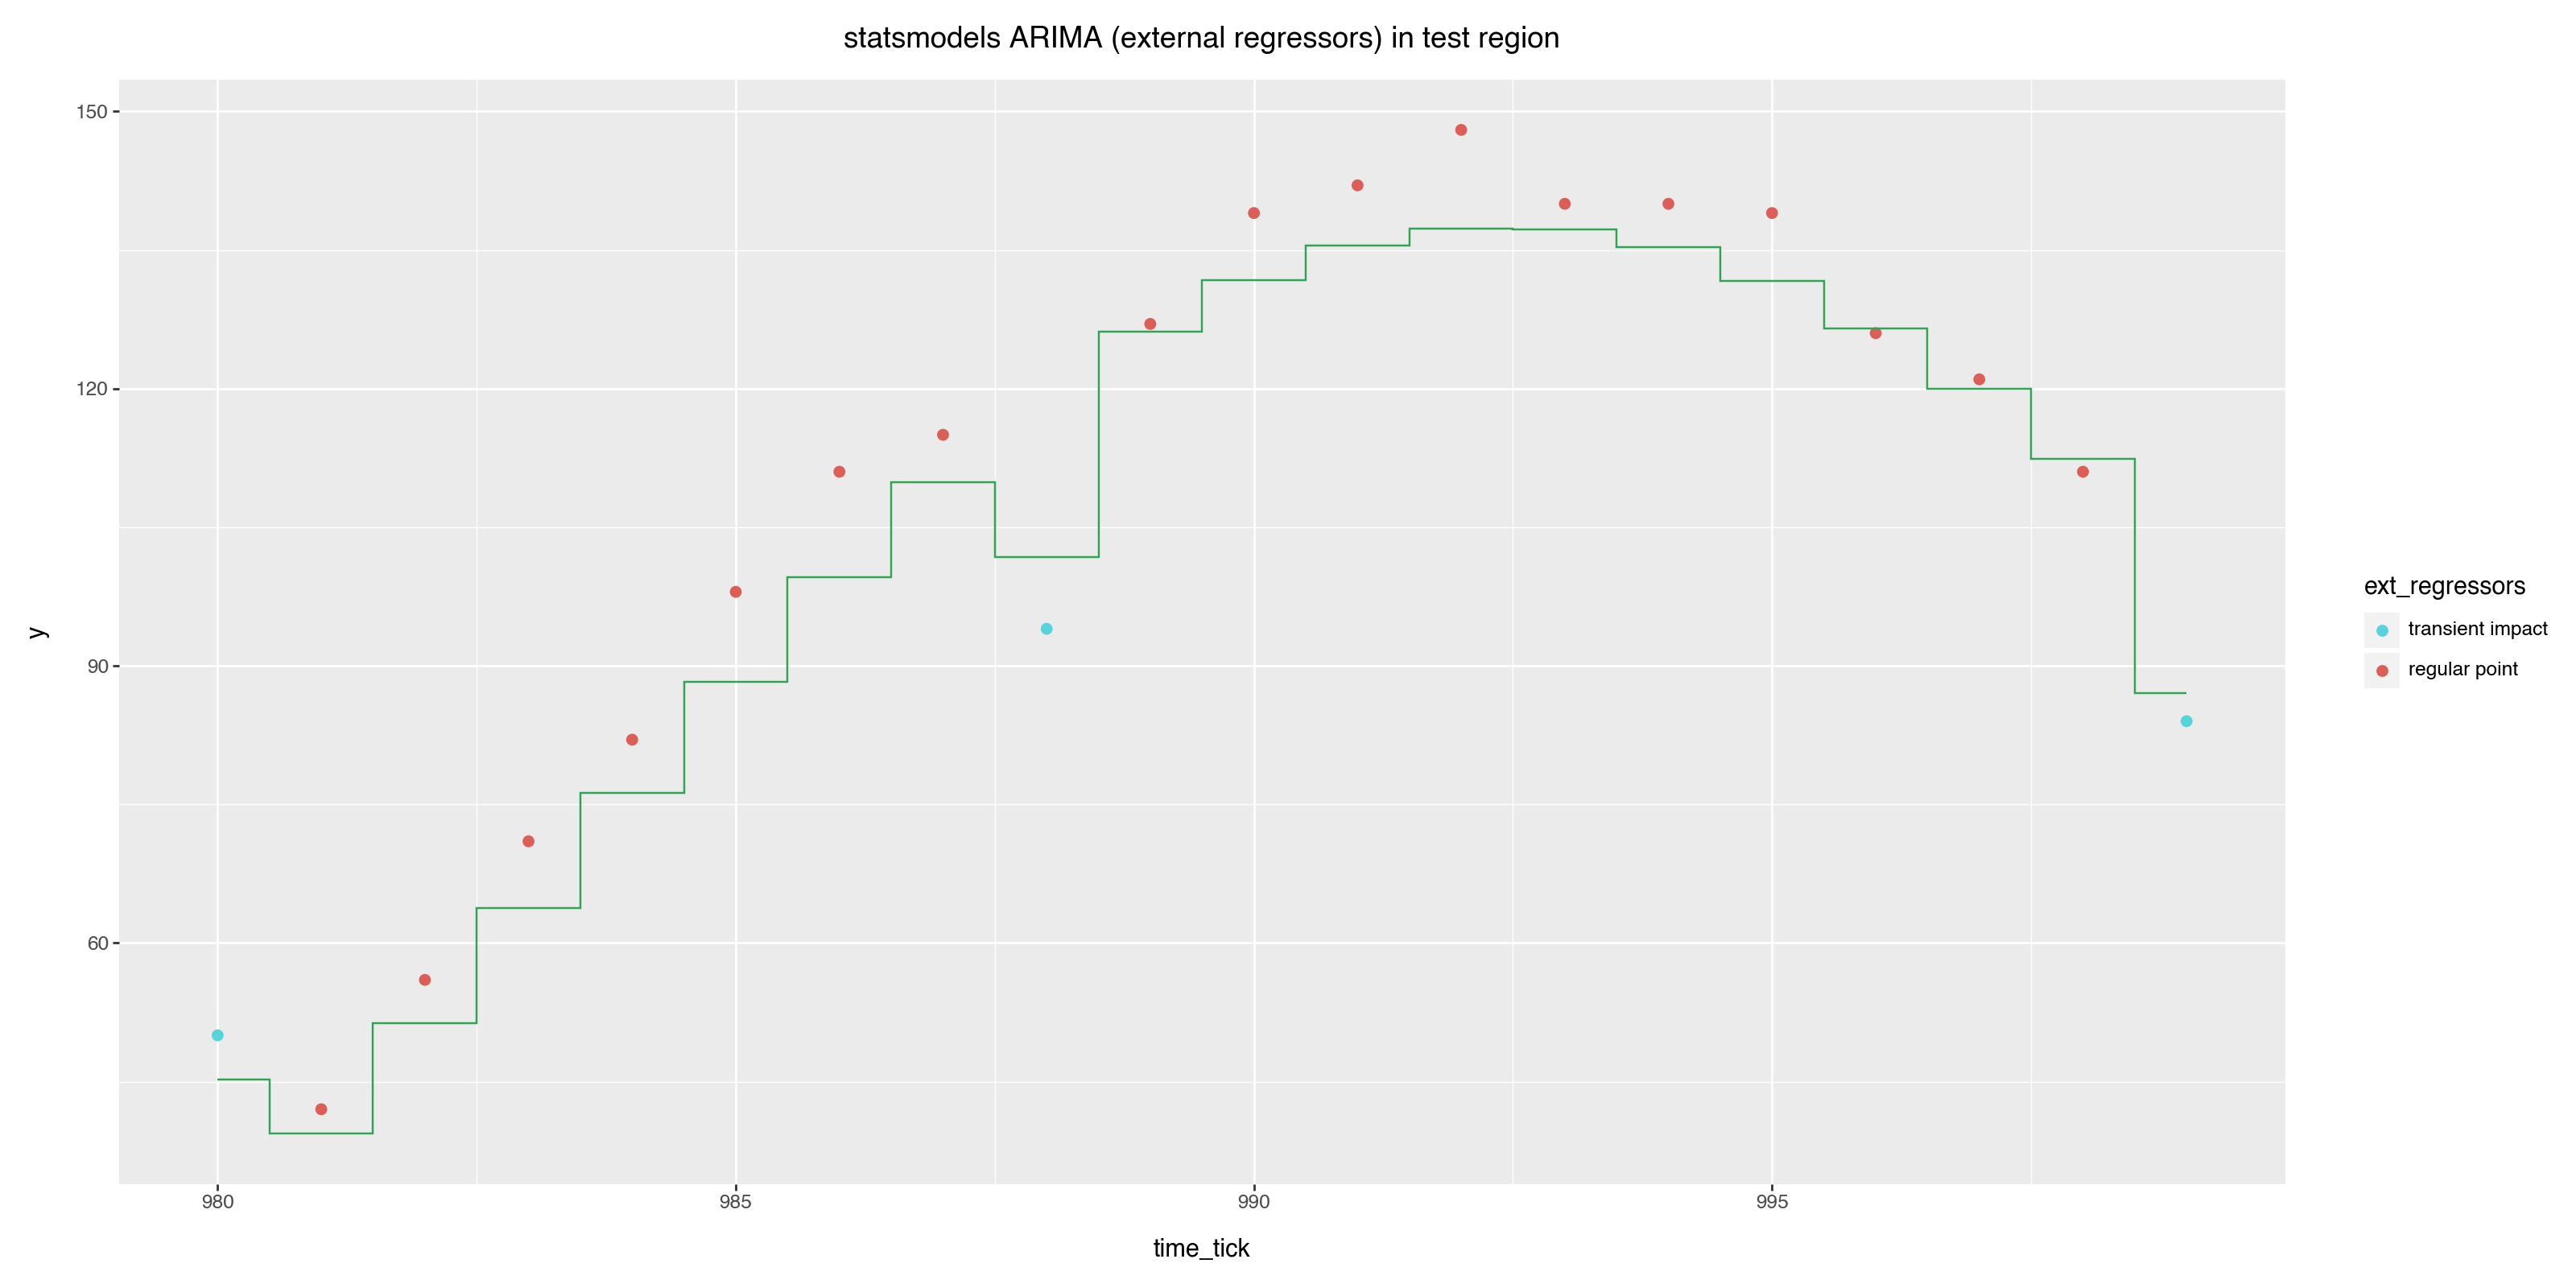

In [8]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis="columns"), :],
        mapping=aes(x="time_tick"),
    )
    + geom_point(
        aes(y="y", color="ext_regressors"),
        size=2,
    )
    + geom_step(
        aes(y="statsmodels ARIMA (external regressors)"),
        color="#31a354",
        direction="mid",
    )
    + guides(color=guide_legend(reverse=True))
    + ggtitle("statsmodels ARIMA (external regressors) in test region")
)

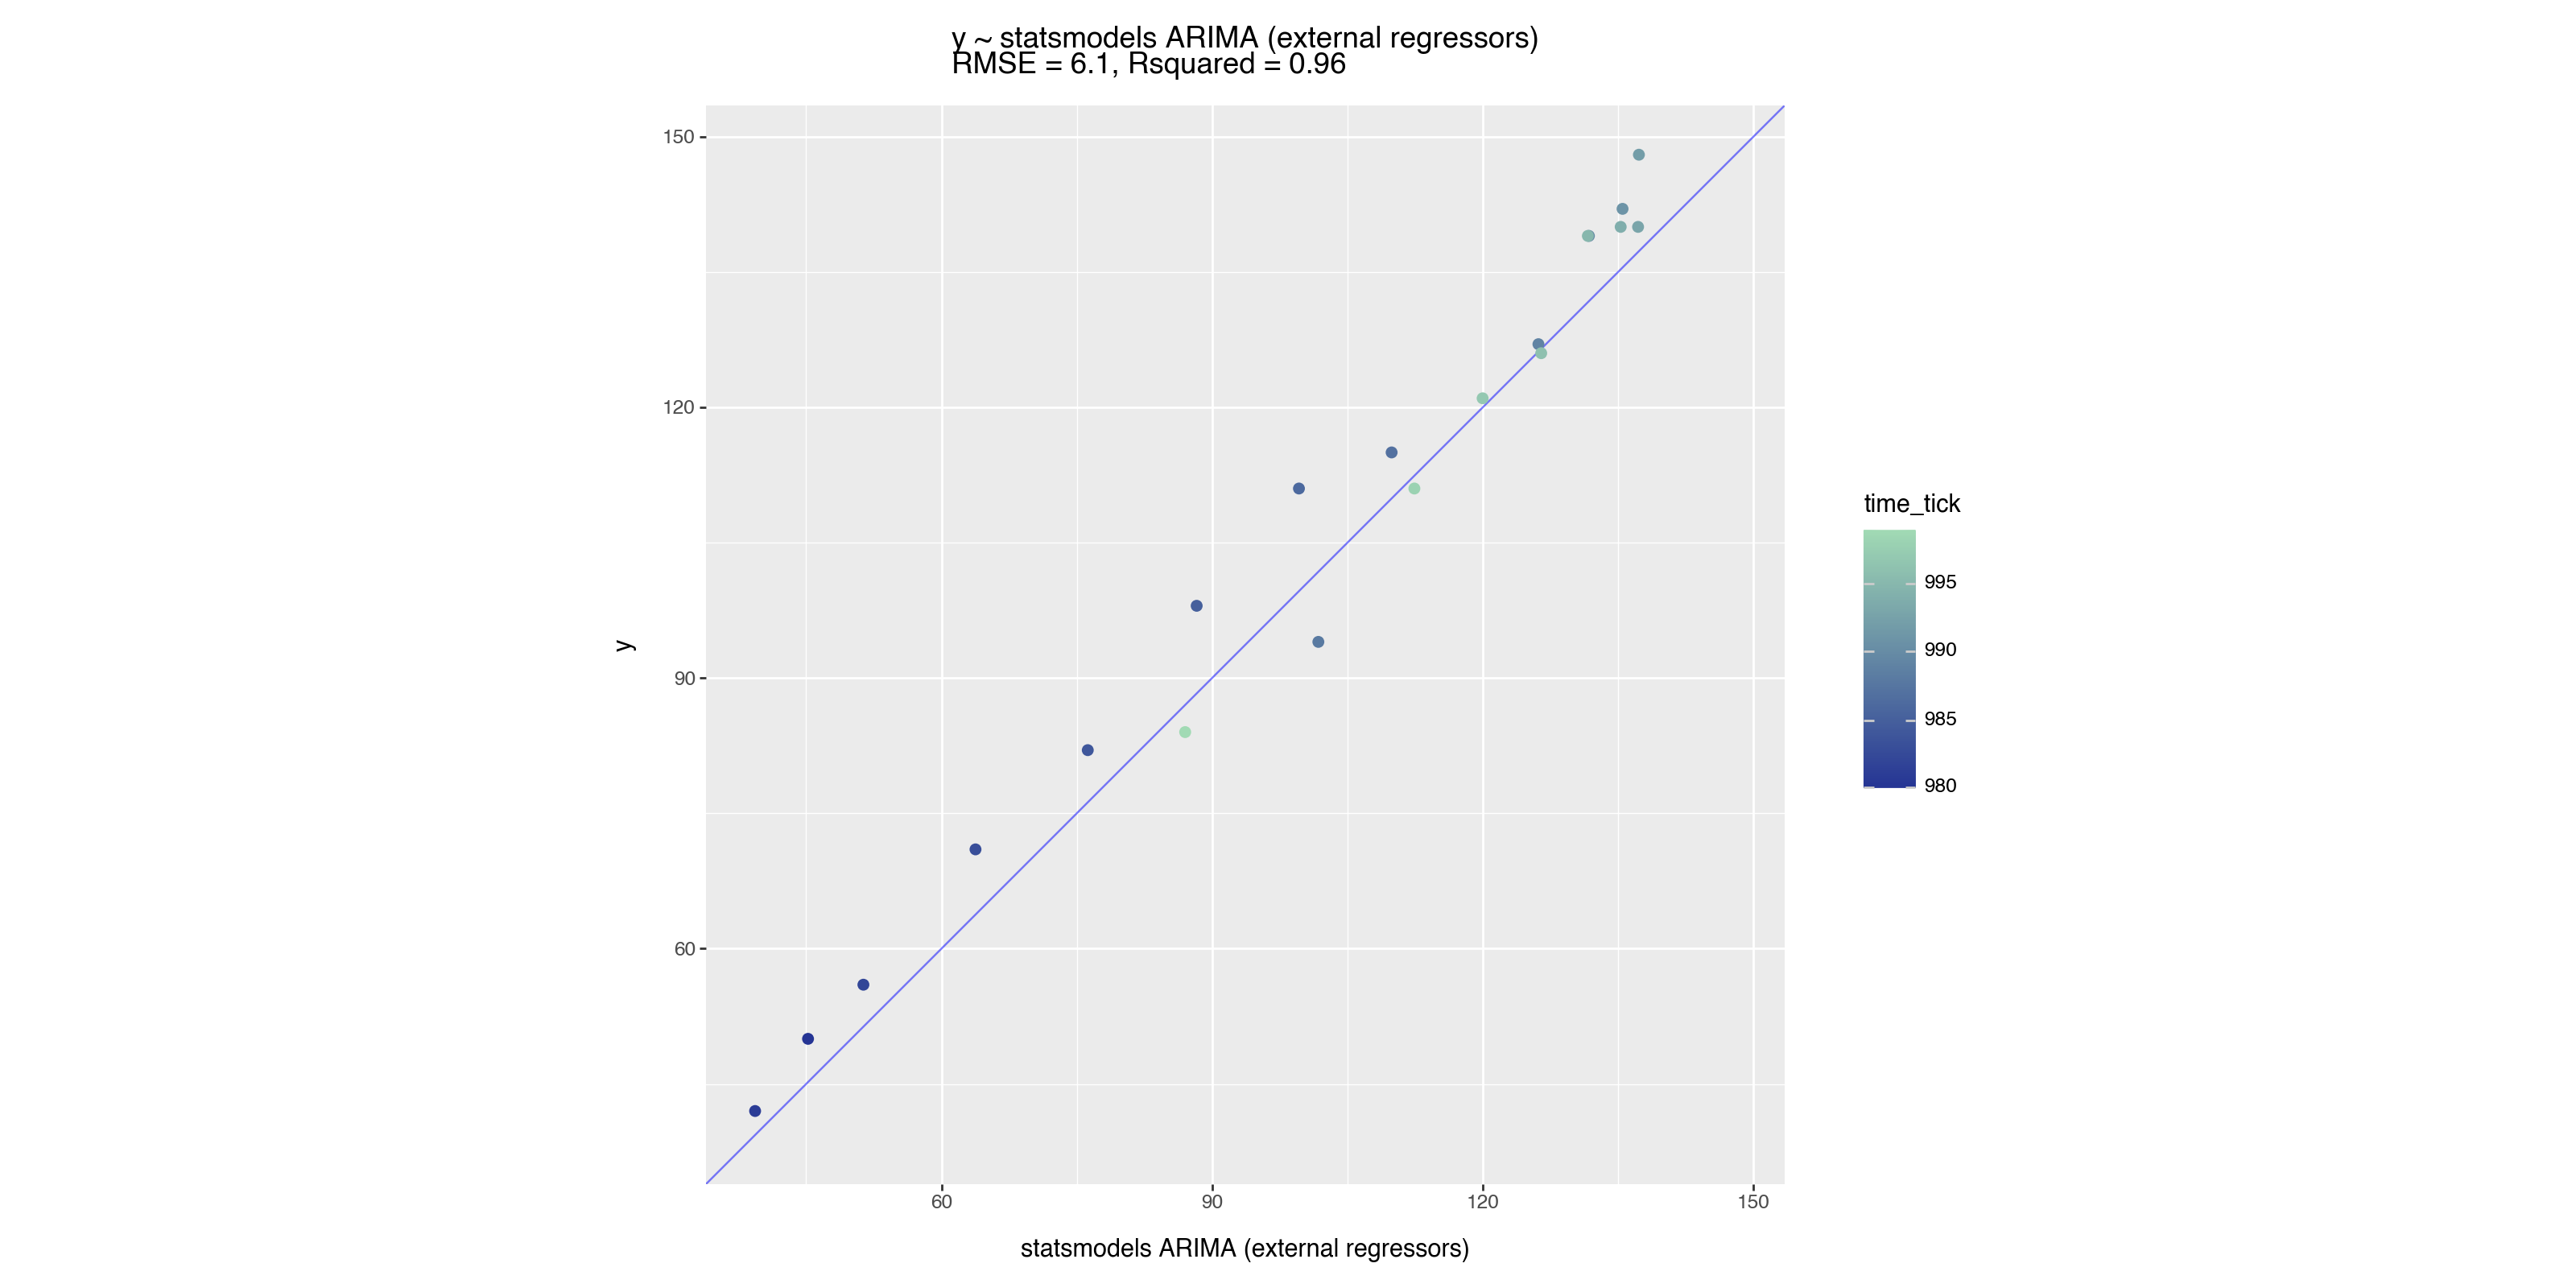

In [9]:
plot_model_quality(
    d_test.loc[
        pd.isnull(d_test["statsmodels ARIMA (external regressors)"]) == False, :
    ],
    result_name="statsmodels ARIMA (external regressors)",
)